# Converge Parameters
We want to find the minimum cutoff energy and buffer around the molecule.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from ase.calculators.cp2k import CP2K
from tempfile import TemporaryDirectory
from contextlib import redirect_stderr
from ase.build import molecule
from ase.io import read
from io import StringIO
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
from ase import units

## Get Example Molecules
We'll test on something with our atom that has the most valence electrons, S.

In [2]:
molecules = pd.read_csv('../../data/example_molecules.csv')
print(f'Loaded a total of {len(molecules)} molecules')

Loaded a total of 12 molecules


In [3]:
row = molecules.iloc[5]
atoms = read(StringIO(row['xyz_neutral']), format='xyz').copy()
atoms

Atoms(symbols='CS3CH6', pbc=False)

CP2K requires us to define a cell even for non-periodic systems

In [4]:
def buffer_cell(atoms, buffer_size: float = 3.): 
    """How to buffer the cell such that it has a vacuum layer around the side
    
    Args:
        atoms: Atoms to be centered
        positions: Size of the buffer to place around the atoms
    """

    atoms.positions -= atoms.positions.min(axis=0)
    atoms.cell = atoms.positions.max(axis=0) + buffer_size * 2
    atoms.positions += atoms.cell.max(axis=0) / 2 - atoms.positions.mean(axis=0)
buffer_cell(atoms)

## Evalute the effect of convergence of buffer size and cutoff
These should be all we need to converge

In [5]:
cp2k_opts = dict(
    xc=None,
    inp="""
&FORCE_EVAL
&DFT
  &XC
     &XC_FUNCTIONAL BLYP
     &END XC_FUNCTIONAL
  &END XC
  &MGRID
      NGRIDS 1
  &END MGRID
  &POISSON
     PERIODIC NONE
     PSOLVER MT
  &END POISSON
  &QS
     EXTRAPOLATION USE_GUESS
  &END QS
&END DFT
&END FORCE_EVAL""",
    basis_set_file='GTH_BASIS_SETS',
    basis_set='TZVP-GTH',
    pseudo_potential='GTH-BLYP',
    poisson_solver=None,
)  # Use BLYP as we have PPs for it
calc = CP2K(charge=-1, uks=True, max_scf=1, directory='mt-conv', **cp2k_opts)

In [6]:
cutoffs = np.arange(200., 1000.1, 50.)
print(f'Testing {len(cutoffs)} energies')

Testing 17 energies


Test many cutoff energies

In [7]:
forces = []
energy = []
for cutoff in tqdm(cutoffs):
    calc.set(cutoff=cutoff * units.Ry)
    forces.append(calc.get_forces(atoms))
    energy.append(calc.get_potential_energy(atoms))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [02:41<00:00,  9.52s/it]


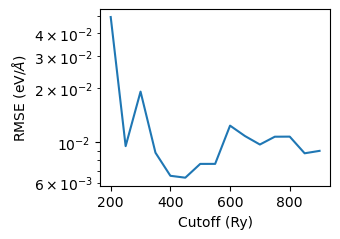

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

rmse = [np.sqrt(np.power(f - forces[-1], 2).mean()) for f in forces]
ax.semilogy(cutoffs[:-2], rmse[:-2])

ax.set_xlabel('Cutoff (Ry)')
ax.set_ylabel('RMSE (eV/$\\AA$)')
fig.tight_layout()

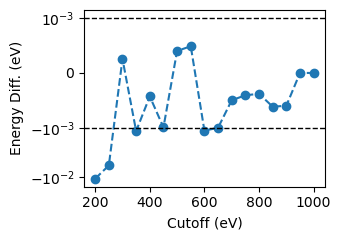

In [12]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(cutoffs, np.subtract(energy, energy[-1]), '--o')

ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [1e-3]*2, 'k--', lw=1)
ax.plot(ax.get_xlim(), [-1e-3]*2, 'k--', lw=1)

ax.set_yscale('symlog', linthresh=1e-3)

ax.set_xlabel('Cutoff (eV)')
ax.set_ylabel('Energy Diff. (eV)')
fig.tight_layout()

It seems like a cutoff of 350 is sufficient.

In [13]:
buffers = np.arange(2., 8.1, 1.)
calc.set(cutoff=750 * units.Ry)

In [14]:
forces = []
energy = []
for b in tqdm(buffers):
    buffer_cell(atoms, buffer_size=b)
    forces.append(calc.get_forces(atoms))
    energy.append(calc.get_potential_energy(atoms))

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 7/11 [10:53<06:13, 93.30s/it]


AssertionError: 

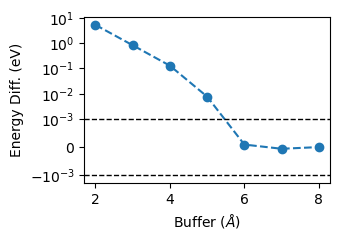

In [16]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(buffers[:len(energy)], np.subtract(energy, energy[-1]), '--o')

ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [1e-3]*2, 'k--', lw=1)
ax.plot(ax.get_xlim(), [-1e-3]*2, 'k--', lw=1)

ax.set_yscale('symlog', linthresh=1e-3)

ax.set_xlabel('Buffer ($\\AA$)')
ax.set_ylabel('Energy Diff. (eV)')
fig.tight_layout()

A buffer of 6 should be OK